In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import DataLoader
import torch
from torch import nn
%matplotlib inline
import matplotlib.pyplot as plt
from dnaDataloader import expermentDataloader
from dnaDataloader import addData
from dnaModelUtil import MLPModel
from datetime import datetime
import json
device = torch.device("cuda:2" if torch.cuda.is_available() else "cpu")
folder = '/home/khood/GitHub/SNN-DNA-project/Prepocessing/sorted/1800_nM_AR_5000'
oneMinInFPS = 1200
batch_size = 10
num_workers = 0
device

device(type='cuda', index=2)

In [2]:

data = expermentDataloader(
    f"{folder}/index.csv",
    f"{folder}",
    length=30*oneMinInFPS
    # length=36000 # 30 min half movie length
    # length=12000  # 10 min movie length
)
# rawData = [(d[0][20*oneMinInFPS:], d[1])for d in data]
rawData = [d for d in data]

featIn 36000


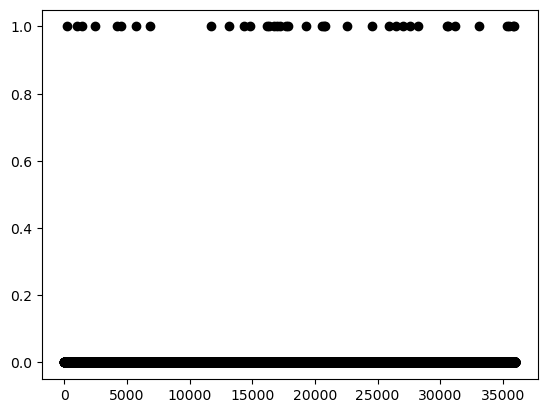

In [3]:
plt.plot(list(range(len(rawData[0][0]))), rawData[0][0], 'o', color='black')
featIn = len(rawData[0][0])
print(f"featIn {featIn}")

In [4]:
len(rawData)

888

In [5]:
featIn = len(rawData[0][0])
trainValidData = []
testData = []
addData(testData, trainValidData, rawData, rhsSize=300)


np.random.shuffle(trainValidData)
trainData = []
validData = []
addData(trainData, validData, trainValidData,
        rhsSize=int(len(trainValidData)*(1/3)))

trainDataset = DataLoader(trainData, batch_size=batch_size,
                          shuffle=True, num_workers=num_workers, pin_memory=True)
validDataset = DataLoader(validData, batch_size=batch_size,
                          shuffle=True, num_workers=num_workers, pin_memory=True)
testDataset = DataLoader(testData, batch_size=len(
    testData), shuffle=True, num_workers=num_workers, pin_memory=True)
print(f"Training dataset size: {len(trainData)}")
print(f"Valid dataset size: {len(validData)}")
print(f"Testing dataset size: {len(testData)}")
print(f"Total: {len(trainData) + len(validData) + len(testData)}")
print(f"number train batches:{len(trainDataset)}")
print(f"number valid batches:{len(validDataset)}")
print(f"number test batches:{len(testDataset)}")

Training dataset size: 200
Valid dataset size: 100
Testing dataset size: 588
Total: 888
number train batches:20
number valid batches:10
number test batches:1


In [6]:
size = int(featIn*0.06)
size = 2160
size

2160

In [7]:
model = MLPModel(featIn=featIn, capacity=1000)
model = model.to(device)
MSE = nn.MSELoss(reduction='mean')
adam = torch.optim.Adam(model.parameters(), lr=0.00001, weight_decay=1e-5)

em = 5
epochs = 800
losses = []
accs = []
accs_t = []
losses_t = []
print("training...")
for e in range(epochs):
    avgLossTrain = []
    currentAccTrain = []
    model.train()
    for i, (inputs, targets) in enumerate(trainDataset):
        inputs, targets = inputs.float().to(device), targets.float().to(device)
        outputs = model(inputs)
        loss = MSE(outputs, targets)
        avgLossTrain.append(float(loss.item()))
        adam.zero_grad()
        loss.backward()
        adam.step()
        totalCorrect = torch.sum(torch.isclose(
            outputs.int(), targets.int(), atol=em))
        totalCorrect = totalCorrect.item()
        currentAccTrain.append(float(totalCorrect/len(targets)))
    accs_t.append(float(np.sum(currentAccTrain)/len(currentAccTrain)))
    losses_t.append(float(np.sum(avgLossTrain)/len(avgLossTrain)))

    avgLoss = []
    currentAcc = []
    model.eval()
    for i, (inputs, targets) in enumerate(validDataset):
        inputs, targets = inputs.float().to(device), targets.float().to(device)
        outputs = model(inputs)
        loss = MSE(outputs, targets)
        outputPlot = outputs.clone().detach().cpu().numpy()
        targetsPlot = targets.clone().detach().cpu().numpy()
        avgLoss.append(float(loss.clone().detach().cpu().numpy()))
        totalCorrect = torch.sum(torch.isclose(
            outputs.int(), targets.int(), atol=em))
        totalCorrect = totalCorrect.clone().detach().cpu().numpy()
        currentAcc.append(float(totalCorrect/len(targets)))
        print(f"\
        epoch: {e}/{epochs}\t \
        Train Loss:{'%.4f' % (np.sum(avgLossTrain)/len(avgLossTrain))} Valid Loss:{'%.4f' % (np.sum(avgLoss)/len(avgLoss))}\t \
        Train accuracy:{'%.2f' % (np.sum(currentAccTrain)/len(currentAccTrain))} Valid accuracy:{'%.2f' % (np.sum(currentAcc)/len(currentAcc))} \
        ", end="\x1b\r")
    accs.append(float(np.sum(currentAcc)/len(currentAcc)))
    losses.append(float(np.sum(avgLoss)/len(avgLoss)))

training...


Best acc: 0.19000000000000003


8000

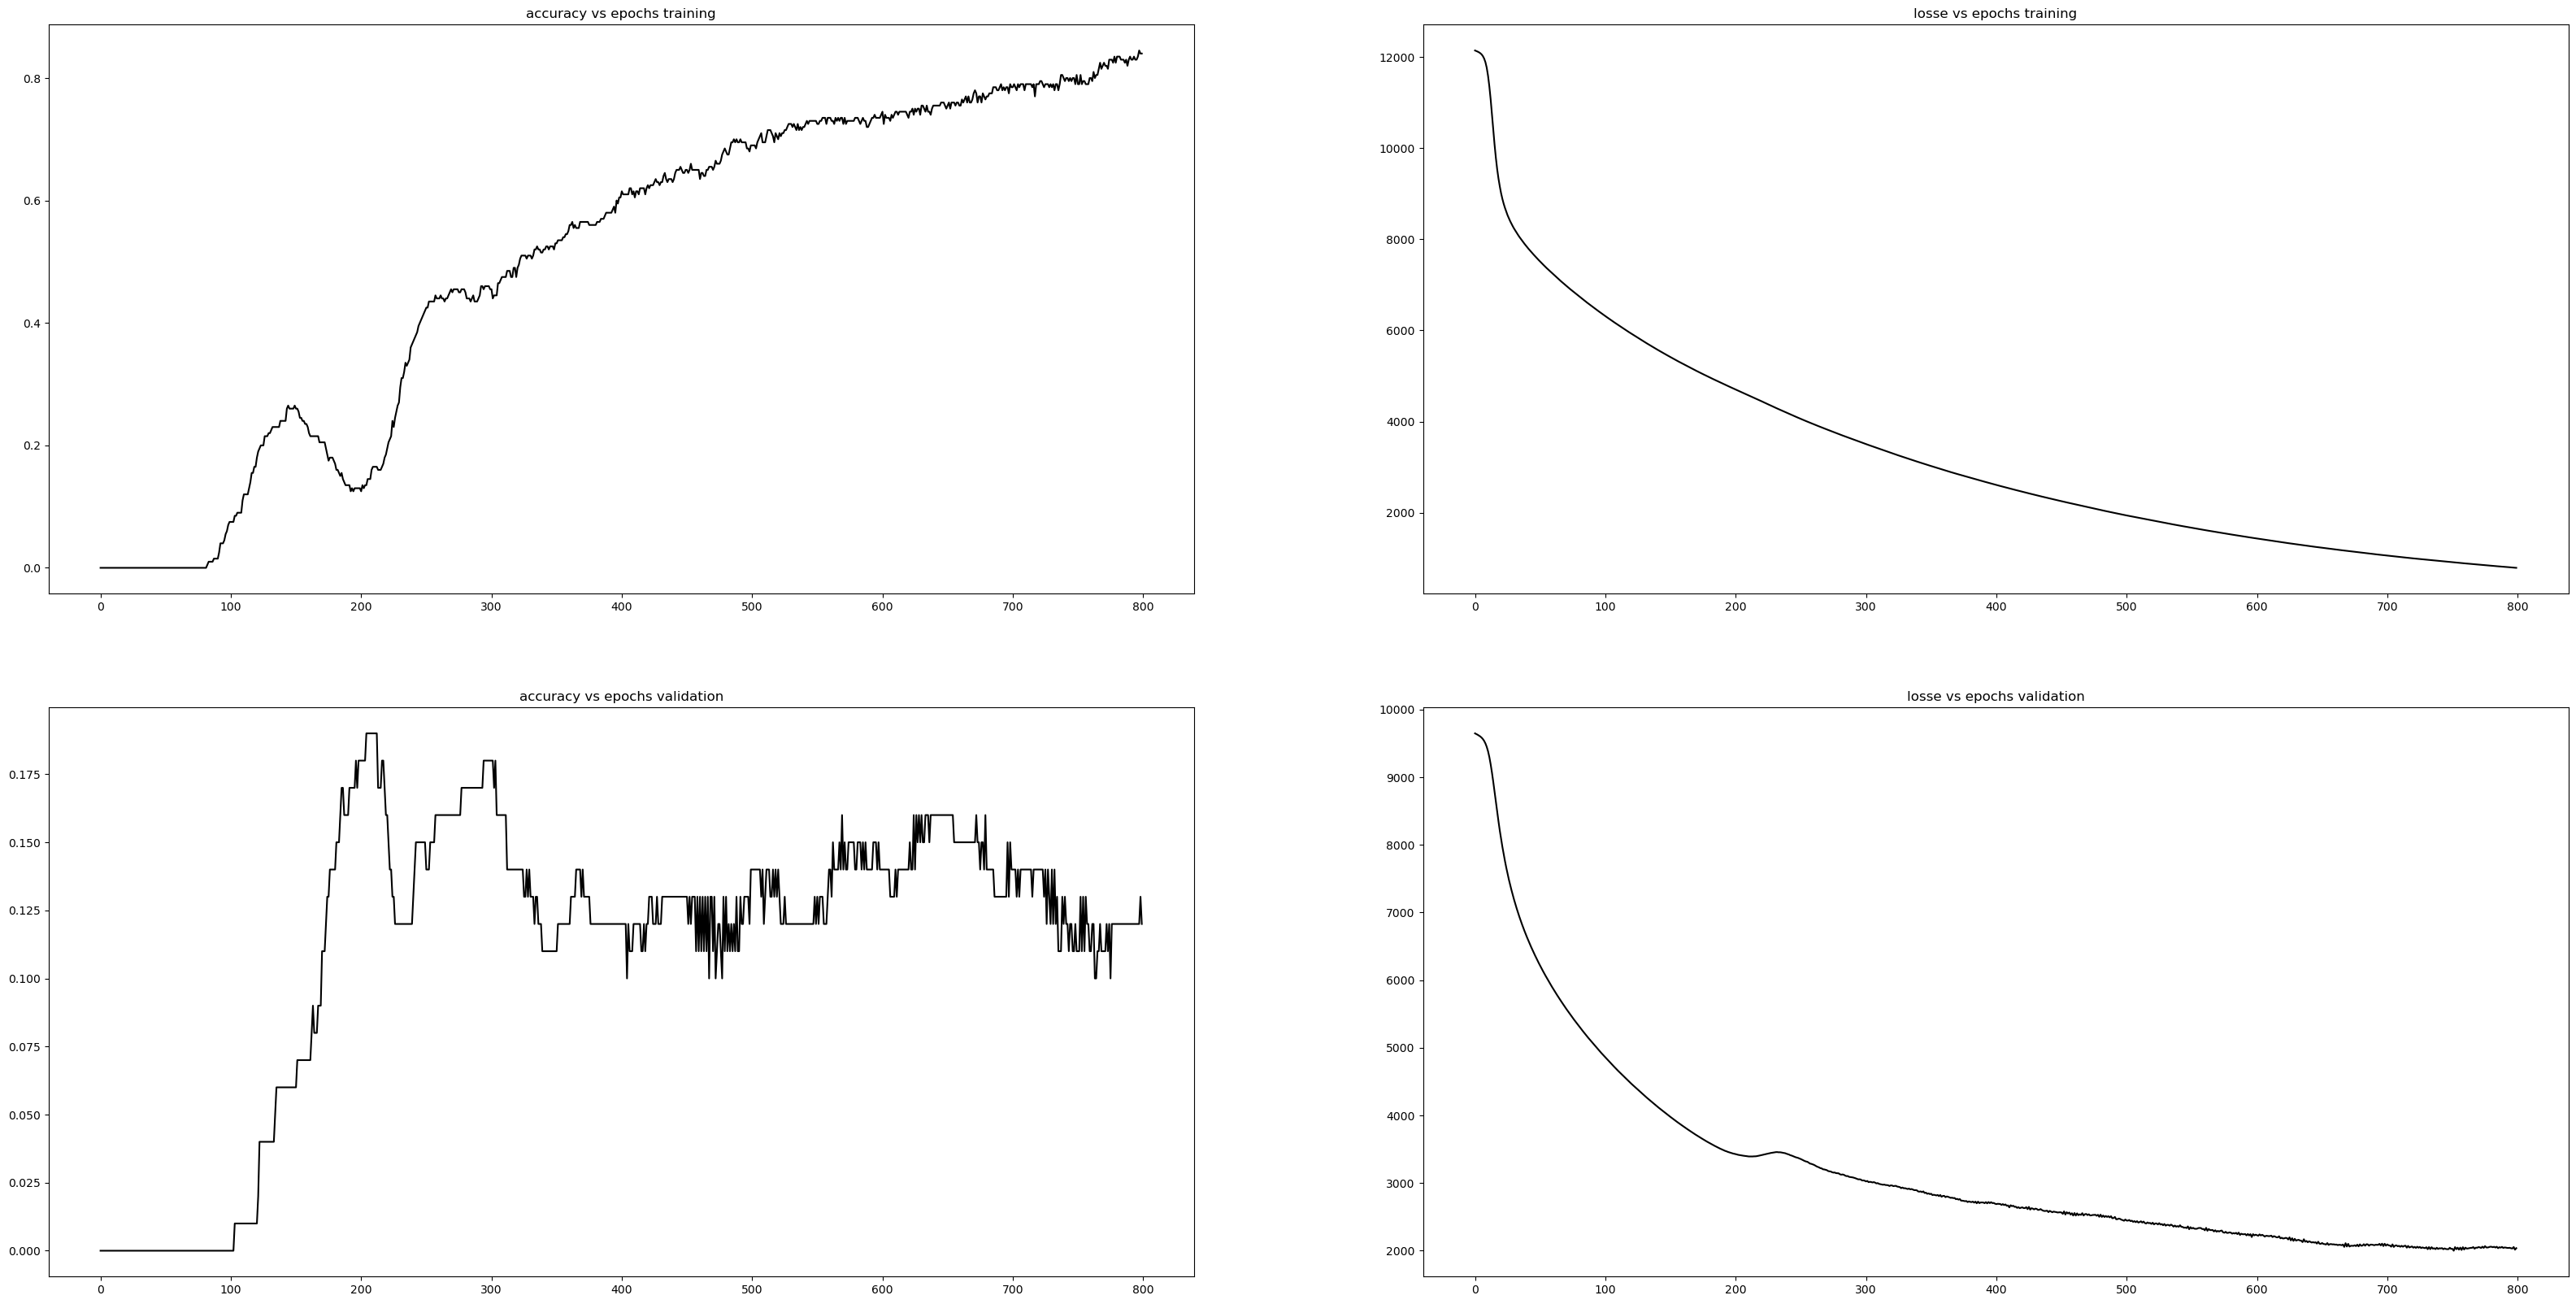

In [8]:
defultePlotSize = plt.rcParams['figure.figsize']
plt.rcParams['figure.figsize'] = [40, 20]

plt.subplot(2, 2, 1)
plt.title(f'accuracy vs epochs training')
plt.plot(list(range(len(accs_t[:]))), accs_t[:], '-', color='black', )
plt.subplot(2, 2, 2)
plt.title(f'losse vs epochs training')
plt.plot(list(range(len(losses_t)))[:], losses_t[:], '-', color='black')

plt.subplot(2, 2, 3)
plt.title(f'accuracy vs epochs validation')
plt.plot(list(range(len(accs[:]))), accs[:], '-', color='black', )
plt.subplot(2, 2, 4)
plt.title(f'losse vs epochs validation')
plt.plot(list(range(len(losses)))[:], losses[:], '-', color='black')
plt.rcParams['figure.figsize'] = defultePlotSize
print(f"Best acc: {max(accs)}")

epochs*len(validDataset)

<em> within 20 events </em><br>
10min ~ 50% <br>
1min ~ 50% <br>
30sec ~ 60% <br>
20 frames ~ 60%

<em> within 5 events </em><br>
10min ~ 20% <br>
20 frames ~ 20% <br>
30 min ~ 20% <br>

In [9]:
title = "trying varied movie length"
dt_string = datetime.now().strftime("%d.%m.%Y_%H-%M-%S-%f")
modelPath = f"./Models/{title.replace(' ', '_')}_{dt_string}.pt"
torch.save(model.state_dict(), modelPath)
print(f"saved to {modelPath}")

saved to ./Models/trying_varied_movie_length_03.07.2023_11-56-06-980172.pt


In [10]:
f = open('/home/khood/GitHub/SNN-DNA-project/Models/variedMovie/mlp_valid_acc.json')
mlp_valid_acc = json.load(f)
mlp_valid_acc = {k: mlp_valid_acc[k]['acc'] for k in mlp_valid_acc}
sorted_mlp_valid_acc = {k: v for k, v in sorted(
    mlp_valid_acc.items(), key=lambda item: item[1])}
sorted_mlp_valid_acc

{'MLP_600_frames': 0.31,
 'MLP_400_frames': 0.32000000000000006,
 'MLP_800_frames': 0.34,
 'MLP_200_frames': 0.35000000000000003,
 'MLP_3800_frames': 0.4,
 'MLP_4400_frames': 0.4,
 'MLP_4200_frames': 0.42000000000000004,
 'MLP_1000_frames': 0.43000000000000005,
 'MLP_5800_frames': 0.45,
 'MLP_5600_frames': 0.45000000000000007,
 'MLP_1400_frames': 0.47000000000000003,
 'MLP_4800_frames': 0.47000000000000003,
 'MLP_1800_frames': 0.49000000000000005,
 'MLP_4600_frames': 0.5000000000000001,
 'MLP_2600_frames': 0.52,
 'MLP_3600_frames': 0.5200000000000001,
 'MLP_3000_frames': 0.53,
 'MLP_5400_frames': 0.53,
 'MLP_3400_frames': 0.5399999999999999,
 'MLP_2800_frames': 0.54,
 'MLP_5000_frames': 0.54,
 'MLP_5200_frames': 0.5400000000000001,
 'MLP_1600_frames': 0.56,
 'MLP_2400_frames': 0.56,
 'MLP_3200_frames': 0.57,
 'MLP_4000_frames': 0.5700000000000001,
 'MLP_1200_frames': 0.5800000000000001,
 'MLP_2200_frames': 0.5800000000000001,
 'MLP_2000_frames': 0.5999999999999999}

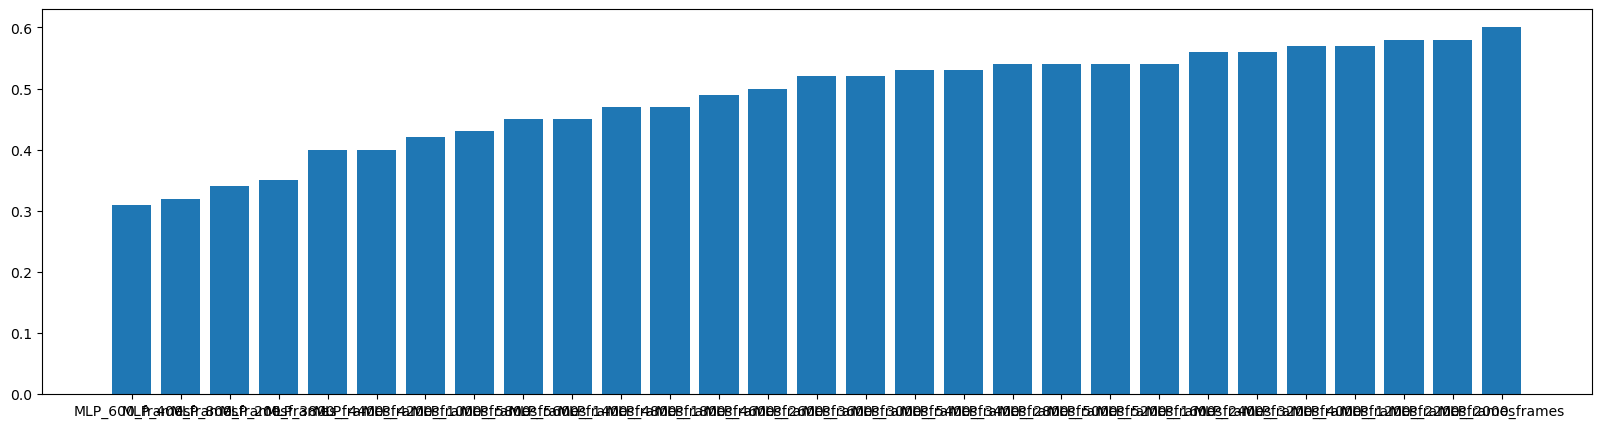

In [11]:
names = list(sorted_mlp_valid_acc.keys())
values = list(sorted_mlp_valid_acc.values())

plt.rcParams['figure.figsize'] = [20, 5]
plt.bar(range(len(sorted_mlp_valid_acc)), values, tick_label=names)
plt.show()